In [1]:
import os
import io
import glob
import sys
import astropy.io.fits
import matplotlib
import numpy as np
import time
import timeit

import psycopg2

import pandas as pd
import pandas.io.sql as psql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

from eCallistoProject import plot_config

module_path = os.path.abspath(os.path.join('radiospectra'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import radiospectra
import config as test_config
from radiospectra.sources import CallistoSpectrogram

from matplotlib.backends.backend_pdf import PdfPages, FigureCanvasPdf, PdfFile

import warnings
warnings.filterwarnings("ignore")

C:\Users\delbe\OneDrive\Desktop\eCallistoValidation\radiospectra\radiospectra\version.py:12: UserWarning: could not determine radiospectra package version; this indicates a broken installation
  warnings.warn(


In [2]:
def move_axes(fig, ax_source, ax_target):
    old_fig = ax_source.figure
    ax_source.remove()
    ax_source.figure = fig
    ax_source.set_ylabel('')
    ax_source.set_xlabel('')
        
    ax_source.set_position(ax_target.get_position())
    ax_target.remove()
    ax_target.set_aspect("equal")
    fig.axes.append(ax_source)
    fig.add_subplot(ax_source)
    
    plt.close(old_fig)

5 channels eliminated
Eliminating sharp jumps between channels ...
22 channels eliminated
min_value:  0
max_value:  60
---


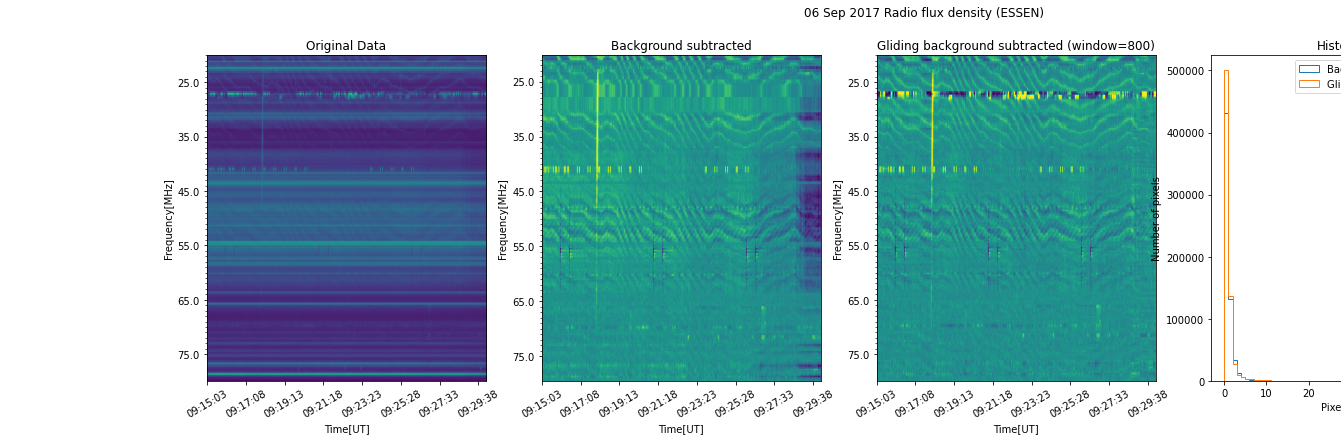

6 channels eliminated
Eliminating sharp jumps between channels ...
22 channels eliminated
min_value:  0
max_value:  42
---


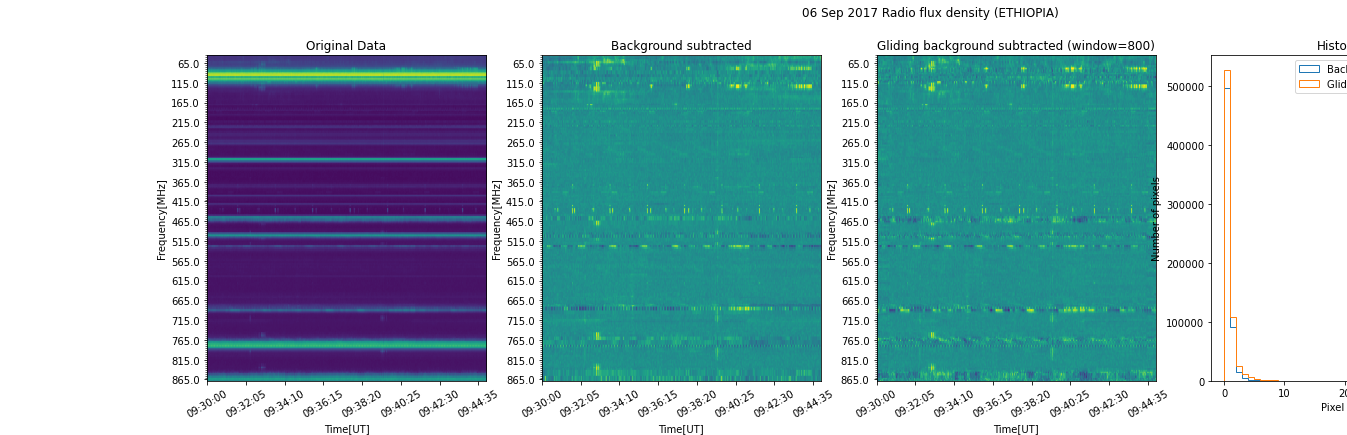

13 channels eliminated
Eliminating sharp jumps between channels ...
8 channels eliminated
min_value:  0
max_value:  38
---


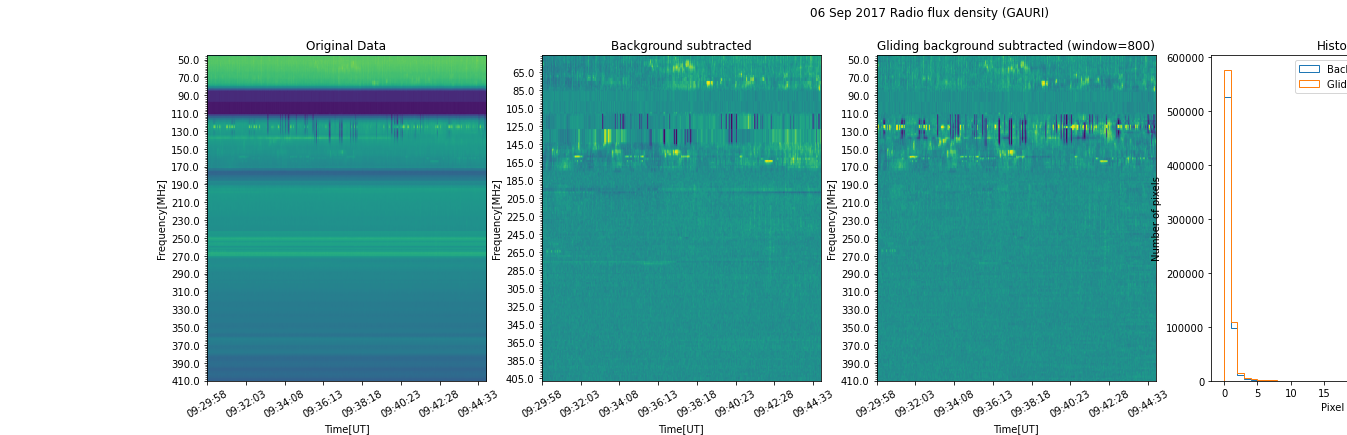

5 channels eliminated
Eliminating sharp jumps between channels ...
18 channels eliminated
min_value:  0
max_value:  69
---


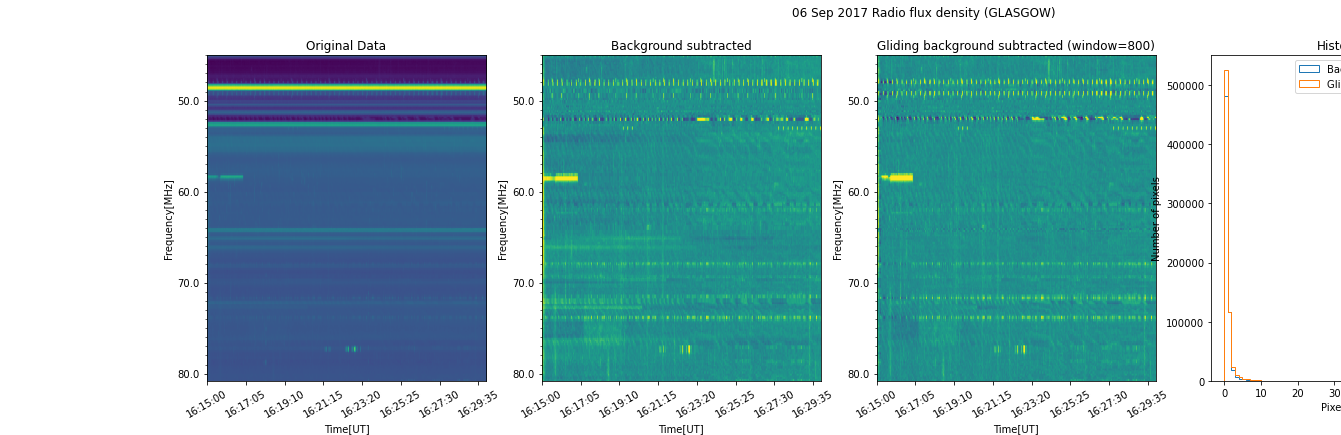

6 channels eliminated
Eliminating sharp jumps between channels ...
14 channels eliminated
min_value:  0
max_value:  24
---


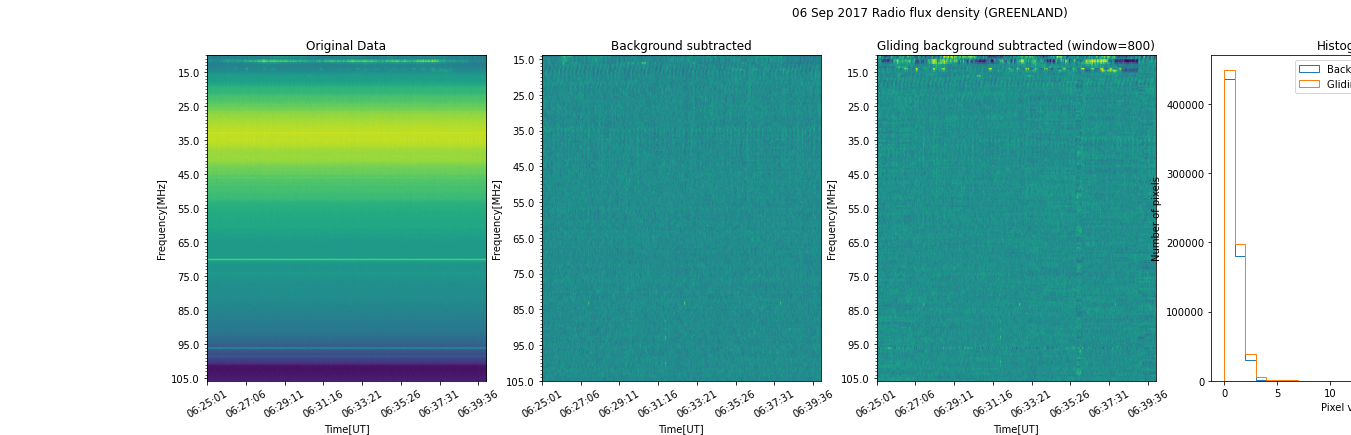

Finished plotting!


In [3]:
Path = 'Spec_test'

with PdfPages('SubBG_Images_test.pdf') as pdf:
    
    for root, dirs, files in os.walk(Path):
        for name in files:
            if name.endswith('.fit.gz'):
                full_path = os.path.join(root, name)
                spec = CallistoSpectrogram.read(full_path)
                fig1, axs1 = plt.subplots(1, 4, figsize=(23, 6))
                ax1 = spec.plot()
                ax1.title.set_text("Original Data")
                plt.close()

                # Second column, Constbacksub + elimwrongchannels
                spec2 = spec.subtract_bg("constbacksub", "elimwrongchannels")
                fig2 = plt.subplots(1, 4, figsize=(23, 6))
                ax2 = spec2.plot(vmin=-5, vmax=5)
                ax2.title.set_text("Background subtracted")
                plt.close()

                # Third column, subtract_bg_sliding_window
                spec3 = spec.subtract_bg("subtract_bg_sliding_window", window_width=800, affected_width=1,
                                         amount=0.05, change_points=True)
                fig3 = plt.figure(figsize=(23, 6))
                ax3 = spec3.plot(vmin=-5, vmax=5)
                ax3.title.set_text("Gliding background subtracted (window=800)")
                plt.close()

                # Fourth column, Histograms
                data_absolute3 = np.absolute(spec2.data.flatten())
                data_absolute4 = np.absolute(spec3.data.flatten())
                fig4, ax4 = plt.subplots(figsize=(23, 6))
                
                data3_remove_NAN = data_absolute3[np.logical_not(np.isnan(data_absolute3))]
                data4_remove_NAN = data_absolute4[np.logical_not(np.isnan(data_absolute4))]
                
#                 absolute_data3[np.isnan(absolute_data3)] = 0
#                 absolute_data4[np.isnan(absolute_data4)] = 0
                
                min_value = int(min(min(data3_remove_NAN), min(data4_remove_NAN)))
                max_value = int(max(max(data3_remove_NAN), max(data4_remove_NAN)))
                
                print("min_value: ", min_value)
                print("max_value: ", max_value)
                print("---")
                
                ax4.hist(data_absolute3, histtype='step', bins=range(min_value, max_value + 1), label='Background subtracted')
                ax4.hist(data_absolute4, histtype='step', bins=range(min_value, max_value + 1), label='Gliding background subtracted')

                ax4.title.set_text("Histograms")
                plt.legend()
                plt.close()

                # Plot final plot by moving axes to the figure
                fig_target, (axA, axB, axC, axD) = plt.subplots(1, 4, figsize=(30,6))
                plt.suptitle(fig1._suptitle.get_text())

                move_axes(fig_target, ax1, axA)
                move_axes(fig_target, ax2, axB)
                move_axes(fig_target, ax3, axC)
                move_axes(fig_target, ax4, axD)

                ax1.set_xlabel('Time[UT]')
                ax1.set_ylabel('Frequency[MHz]')

                ax2.set_xlabel('Time[UT]')
                ax2.set_ylabel('Frequency[MHz]')

                ax3.set_xlabel('Time[UT]')
                ax3.set_ylabel('Frequency[MHz]')

                ax4.set_xlabel('Pixel values')
                ax4.set_ylabel('Number of pixels')

                plt.show()
                
            pdf.savefig(fig_target)
            plt.close()


    print("Finished plotting!")